In [1]:
from netCDF4 import Dataset

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fileName = '../../ETOPO1_Ice_c_gmt4.grd'

fh = Dataset(fileName, mode='r')

fh.variables.keys()

x = fh.variables['x']
y = fh.variables['y']
z = fh.variables['z']

In [3]:
x

<class 'netCDF4._netCDF4.Variable'>
float64 x(x)
    long_name: Longitude
    actual_range: [-180.  180.]
    units: degrees_east
unlimited dimensions: 
current shape = (21600,)
filling off

In [4]:
y

<class 'netCDF4._netCDF4.Variable'>
float64 y(y)
    long_name: Latitude
    actual_range: [-90.  90.]
    units: degrees_north
unlimited dimensions: 
current shape = (10800,)
filling off

In [5]:
z

<class 'netCDF4._netCDF4.Variable'>
int32 z(y, x)
    long_name: z
    _FillValue: -2147483648
    actual_range: [-10803.   8333.]
unlimited dimensions: 
current shape = (10800, 21600)
filling off

In [6]:
dx = np.diff(x[:])[0]
dy = np.diff(y[:])[0]
print('dx={}, dy={}'.format(dx,dy))

dx=0.01666666666667993, dy=0.01666666666666572


I want the rectangle $ (lon,lat) \in [-240,-120] \times [-60, 60] $, but can only use  $lon \in[-180,180]$, hence have to use the joined set: $$lon \in [120,180] \cup [-180,-120]$$

Cut in x direction

In [9]:
x0 = 135
x1 = 180
i0 = int((x0+180)*60)
i1 = int((x1+180)*60)
print(i0,np.argmin(np.abs(x0-x[:])))
print(i1,np.argmin(np.abs(x1-x[:])))

18900 18899
21600 21599


In [10]:
x[:].min(),x[:].max()

(-179.99166666666667, 179.99166666666667)

Cut in y direction

In [11]:
y0 = -10
y1 = 50
j0 = int((y0+90)*60)
j1 = int((y1+90)*60)
print(j0, np.argmin(np.abs(y0-y[:])))
print(j1, np.argmin(np.abs(y1-y[:])))

4800 4799
8400 8399


Select bathymetry from range and skip some values

In [12]:
# z0 = z[j0:(j1+1),i0:]
# z1 = z[j0:(j1+1),:i1]
# zfinal = np.hstack([z0,z1])
zfinal = z[j0:(j1+1),i0:(i1+1)][::2,::2]

In [13]:
zfinal.shape

(1801, 1350)

(0.0, 1350.0, 0.0, 1801.0)

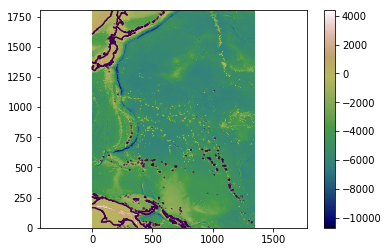

In [14]:
plt.pcolormesh(zfinal[::1,::1],cmap=plt.cm.gist_earth)
plt.colorbar()
plt.contour(zfinal[::1,::1],[0.0])
plt.axis('equal')

In [15]:
np.savetxt('bathymetry',-zfinal[::1,::1])

In [16]:
zfinal[::1,::1].shape

(1801, 1350)

# Easywave

In [17]:
def writeGRD(x,y,z,name):
    ncols = z.shape[1]
    nrows = z.shape[0]
    xll  = x.min()
    xur  = x.max()
    yll = y.min()
    yur = y.max()
    f = open(name,'w')
    f.write('DSAA\n')
    f.write('%i %i\n'%(ncols, nrows))
    f.write('%.3f %.3f\n'%(xll,xur))
    f.write('%.3f %.3f\n'%(yll,yur))


    f.write('%.3f %.3f\n'%(z.min(),z.max()))

    s = [' '.join(['%.5f '%num for num in z[-i,:]]) for i in range(z.shape[0])]

    for ss in s:
        f.write('%s\n'%ss)
    f.close()

writeGRD(x[i0:(i1+1)],y[j0:(j1+1)],np.flipud(zfinal),'bathymetry.grd')

# Geoclaw

In [18]:
z = zfinal

In [19]:
1/60

0.016666666666666666

In [20]:
np.diff(x)

array([ 0.01666667,  0.01666667,  0.01666667, ...,  0.01666667,
        0.01666667,  0.01666667])

In [21]:
ncols = z.shape[1]
nrows = z.shape[0]
xll = 135.0
yll = -10.0
cell = 1/60*2
xur = xll + (ncols-1)*cell
yur = yll + (nrows-1)*cell

header = '''{mx} \t mx
{my} \t my
{xllcorner} \t xllcorner
{yllcorner} \t yllcorner
{cellsize} \t cellsize
{nodatavalue} \t nodataval
'''.format(**{
    'mx':ncols,
    'my':nrows,
    'xllcorner':xll,
    'yllcorner':yll,
    'cellsize':cell,
    'nodatavalue':99999
})
print(header)

1350 	 mx
1801 	 my
135.0 	 xllcorner
-10.0 	 yllcorner
0.03333333333333333 	 cellsize
99999 	 nodataval



In [22]:
outstr = header + ' '.join(map(lambda zi: str(zi)+'\n', np.flipud(zfinal).flatten()))

f = open('bathymetry.tt2','w')
f.write(outstr)
f.close()